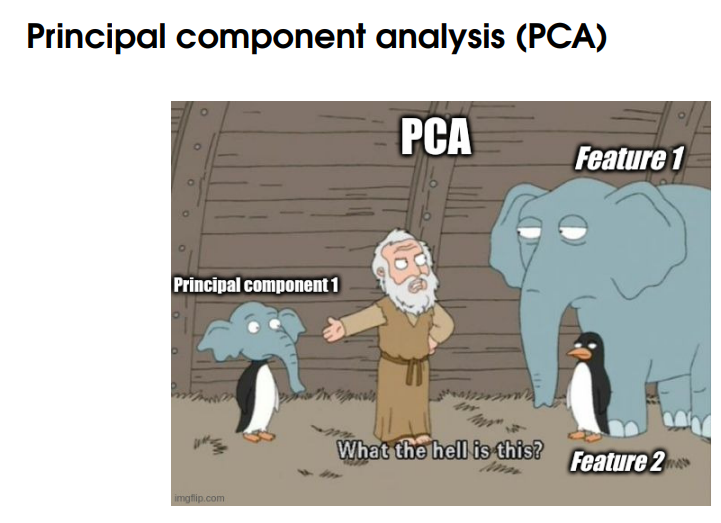

### What is PCA?

- Statistical technique that simplifies a data table consisting of cases and variables into its fundamental characteristics, known as principal components.


- These principal components are linear combinations of the original variables.


- A small number of principal components capture most of the variability in the data, (similar to 80-20 rule).


- The original data table can be approximated using only these few principal components.

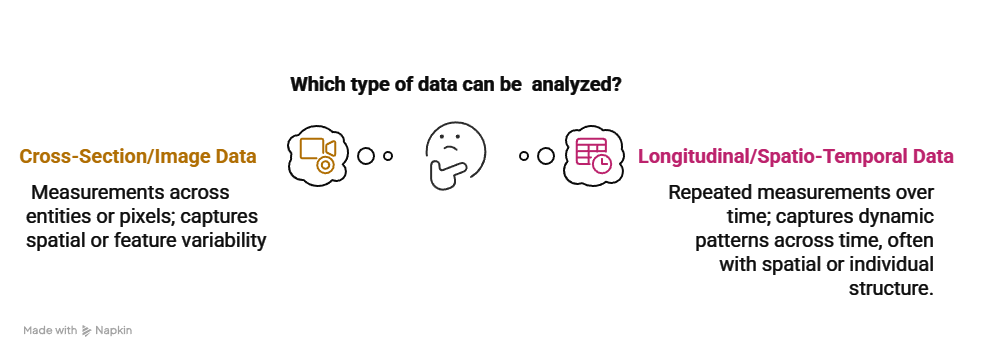

#### Insights gained through PCA

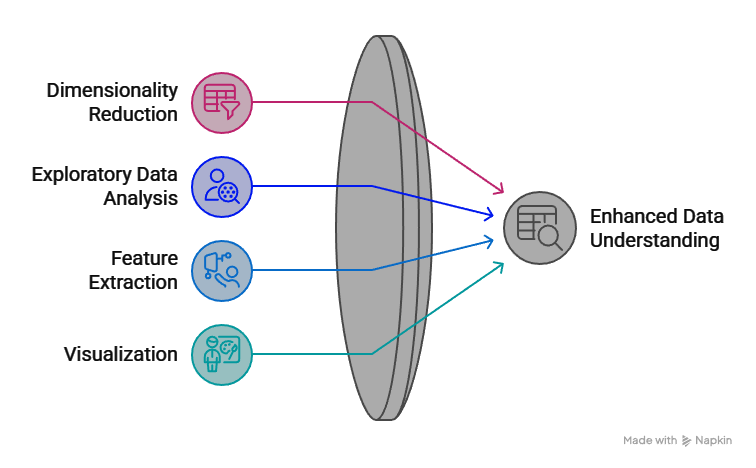

#### Applications

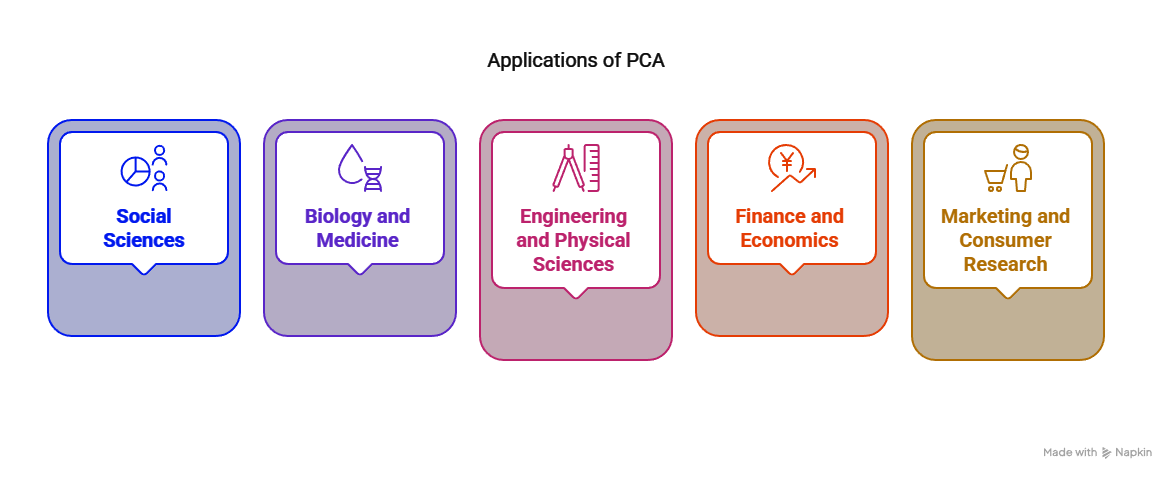

---

## Case study - 1: Dimension reduction of spatio-temporal Data

<video controls src="media_files/SpringMassOscillation3D.mp4" title="Title"></video>

#### Objective: We want to learn the dynamics of the block from the 2D video data from 3 cameras

- We assume that we do not know how the mass actually moves.

- Our collected data has 6 timeseries. $x_i(t)\,,y_i(t)$ from each camera ($i=1,2,3$)

- THE TRUE DIMENSIONALITY OF THE DATA IS 1 ! 

- We will use PCA to identify the true dimensionality.

Define the data matrix $W \in \mathbb{R}^{n \times 6}$, which contains the 2D time series from 3 cameras each providing $x$ and $y$ values. With $n$ time steps and 6 features: $x$ and $y$ from 3 cameras looks like this:


$$
X =
\begin{bmatrix}
x_1(t_1) & y_1(t_1) & x_2(t_1) & y_2(t_1) & x_3(t_1) & y_3(t_1) \\
x_1(t_2) & y_1(t_2) & x_2(t_2) & y_2(t_2) & x_3(t_2) & y_3(t_2) \\
\vdots & \vdots & \vdots & \vdots & \vdots & \vdots \\
x_1(t_n) & y_1(t_n) & x_2(t_n) & y_2(t_n) & x_3(t_n) & y_3(t_n)
\end{bmatrix}
$$


- Each **row** corresponds to one time step $t_k$.
- Each **column** corresponds to a specific signal: either $x_i(t)$ or $y_i(t)$ from camera $i$.

**PART 1**

#### Data-generation

In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sci_mplstyle_package
from matplotlib.ticker import MaxNLocator

# Use STIX font and enable LaTeX-style math rendering
plt.rcParams.update({
    "figure.dpi": 100
})
# plt.rcParams.keys()

Duplicate key in file 'c:\\Users\\suparnob\\AppData\\Local\\anaconda3\\envs\\pca_tutorial\\Lib\\site-packages\\sci_mplstyle_package\\style_files\\publication.mplstyle', line 64 ('axes.axisbelow : True')


In [2]:
from data_generation import data_gen

In [3]:
data, t_values = data_gen()

In [4]:
# Stack the six time series into a data matrix.
# Each row corresponds to a time step and the columns are:
# [Cam1_x, Cam1_y, Cam2_x, Cam2_y, Cam3_x, Cam3_y]

X = np.column_stack([data["Camera_1"]["x"],
                     data["Camera_1"]["y"],
                     data["Camera_2"]["x"],
                     data["Camera_2"]["y"],
                     data["Camera_3"]["x"],
                     data["Camera_3"]["y"]])

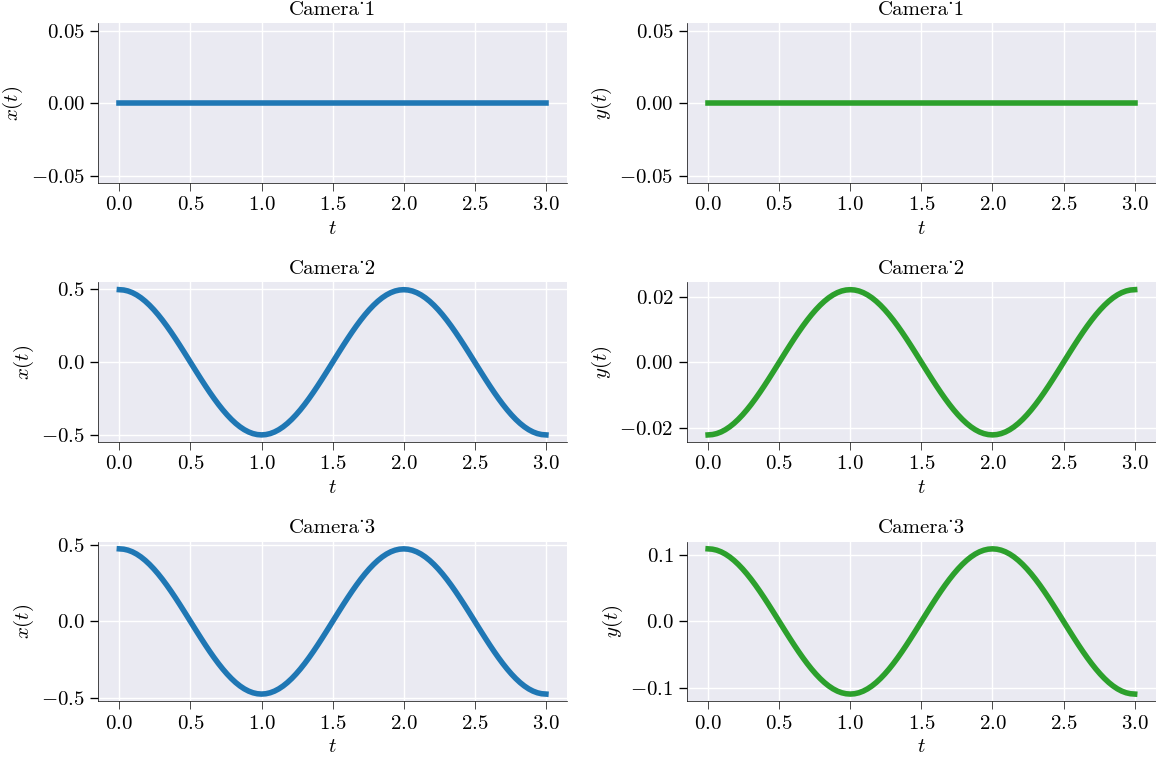

In [5]:
# Plot x and y time series for each camera
fig, axs = plt.subplots(3, 2, figsize=(12, 8))
camera_names = ["Camera_1", "Camera_2", "Camera_3"]

for i, cam in enumerate(camera_names):
    axs[i, 0].plot(t_values, data[cam]["x"], color='tab:blue',lw=4)
    axs[i, 0].set_title(f"{cam}")
    axs[i, 0].set_xlabel("$t$")
    axs[i, 0].set_ylabel("$x(t)$")

    axs[i, 1].plot(t_values, data[cam]["y"], color='tab:green',lw=4)
    axs[i, 1].set_title(f"{cam}")
    axs[i, 1].set_xlabel("$t$")
    axs[i, 1].set_ylabel("$y(t)$")

plt.tight_layout()
plt.show()


### Variance and covariance

**Variance:** The variance of a vector $\mathbf{a}$ with elements $ a_i $ (for $ i = 1, 2, \dots, n $) measures the spread of its elements around their mean. It is defined as:

$$
\text{Var}(\mathbf{a}) = \frac{1}{n-1} \sum_{i=1}^{n} (a_i - \bar{a})^2
$$

where $ \bar{a} = \frac{1}{n} \sum_{i=1}^{n} a_i $ is the mean of the vector. A higher variance indicates that the values are more dispersed from the mean, while a lower variance suggests they are more concentrated around it.

If $\overline{a} = 0$, variance can be expressed as a dot product

$$
\text{Var}(a) = \frac{1}{n-1} \mathbf{a} \cdot \mathbf{a}
$$

.

 **Covariance:** The covariance between two vectors **a** and **b**, each with $ n $ elements $ a_i $ and $ b_i $, measures how much the two variables change together. It is defined as:

$$
\text{Cov}(a, b) = \frac{1}{n-1} \sum_{i=1}^{n} (a_i - \bar{a})(b_i - \bar{b})
$$

where $ \bar{a} $ and $ \bar{b} $ are the means of vectors **a** and **b**, respectively.

- A **positive** covariance means that as $ a_i $ increases, $ b_i $ tends to increase as well.
- A **negative** covariance indicates that as $ a_i $ increases, $ b_i $ tends to decrease.
- A **zero** covariance suggests no linear relationship between the two.

Covariance is the fundamental building block of the **covariance matrix** used in PCA.

Assuming the vectors $\mathbf{a}$ and $\mathbf{b}$ have **zero mean**, the **covariance** can be written using the dot product as:

$$
\text{Cov}(\mathbf{a}, \mathbf{b}) = \frac{1}{n-1} \, \mathbf{a} \cdot \mathbf{b}
$$

where:
- $\mathbf{a} \cdot \mathbf{b} = \sum_{i=1}^{n} a_i b_i$ is the dot product,
- $n$ is the number of elements.

### Covariance Matrix

The **covariance matrix** is a square matrix that summarizes the pairwise covariances between multiple zero-mean random variables (or features). For a data matrix $X \in \mathbb{R}^{n \times d}$, where each of the $n$ rows is a sample and each of the $d$ columns is a feature (assumed to have zero mean), the covariance matrix is defined as:

$$
\Sigma = \frac{1}{n} X^\top X
$$

Each entry of $\Sigma$ is given by:

$$
\Sigma_{ij} = \text{Cov}(x_i, x_j) = \frac{1}{n} \sum_{k=1}^{n} x_{ki} x_{kj}
$$


- The **diagonal entries** $\Sigma_{ii}$ represent the variances of individual features.
- The **off-diagonal entries** $\Sigma_{ij}$ represent the covariances between features $i$ and $j$.

$$
X =
\begin{bmatrix}
x_1(t_1) & y_1(t_1) & x_2(t_1) & y_2(t_1) & x_3(t_1) & y_3(t_1) \\
x_1(t_2) & y_1(t_2) & x_2(t_2) & y_2(t_2) & x_3(t_2) & y_3(t_2) \\
\vdots & \vdots & \vdots & \vdots & \vdots & \vdots \\
x_1(t_n) & y_1(t_n) & x_2(t_n) & y_2(t_n) & x_3(t_n) & y_3(t_n)
\end{bmatrix}
$$


$$
\Sigma = \frac{1}{n-1}
\begin{bmatrix}
\text{Var}(x_1) & \text{Cov}(x_1, y_1) & \cdots & \cdots & \cdots & \cdots \\
               & \text{Var}(y_1)       & \text{Cov}(y_1, x_2) & \cdots & \cdots & \cdots \\
               &                      & \text{Var}(x_2) & \text{Cov}(x_2, y_2) & \cdots & \cdots \\
               &                      &                 & \text{Var}(y_2) & \text{Cov}(y_2, x_3) & \cdots \\
               &                      &                 &                 & \text{Var}(x_3) & \text{Cov}(x_3, y_3) \\
               &                      &                 &                 &                 & \text{Var}(y_3)
\end{bmatrix}
$$


### Question: can I (linearly) transform X such that $\Sigma$ becomes diagonal?



<u>Step 1: Apply a linear transformation</u>


Let $X \in \mathbb{R}^{n \times d}$ be the mean-centered data matrix.  
We apply a linear transformation using a matrix $W \in \mathbb{R}^{d \times d}$:

$$
Z = XW
$$

The covariance matrix of the transformed data $Z$ is:

$$
\Sigma_Z = \frac{1}{n} Z^\top Z = \frac{1}{n} (XW)^\top (XW) = W^\top \left( \frac{1}{n} X^\top X \right) W = W^\top \Sigma W
$$

where $\Sigma = \frac{1}{n} X^\top X$ is the covariance matrix of $X$.


<u>Step 2: Goal — make $\Sigma_Z$ diagonal</u>

We want to choose $W$ such that:

$$
W^\top \Sigma W = D
$$

where $D$ is a diagonal matrix. That is, we seek a **linear transformation** that makes the features of $Z$ **uncorrelated**.


<u>Step 3: Solve the covariance eigenvalue problem</u>

This leads us to the **eigenvalue problem**:

$$
\Sigma \vec{v} = \lambda \vec{v}
$$

Let $V$ be the matrix whose columns are the eigenvectors $\vec{v}_1, \dots, \vec{v}_d$, and let $\Lambda = \text{diag}(\lambda_1, \dots, \lambda_d)$ be the corresponding diagonal matrix of eigenvalues. Then:

$$
\Sigma = V \Lambda V^\top
$$

Setting $W = V$ gives:

$$
\Sigma_Z = V^\top \Sigma V = \Lambda
$$



Choosing $W$ as the eigenvector matrix of $\Sigma$ diagonalizes the covariance matrix of $XW$. This is the foundation of **PCA**, where the eigenvectors define the principal directions and the eigenvalues represent the variance along those directions.

In [6]:
def pca_from_covariance(X):
    
    n = X.shape[0]  # number of samples

    # Step 0: Preprocess the data
    
    X_standardized = X - np.mean(X, axis=0)

    
    # Step 1: Compute the covariance matrix
    Sigma = (1 / (n-1)) * X_standardized.T @ X_standardized  # shape (d, d)


    # Step 2: Solve the eigenvalue problem
    eigenvalues, eigenvectors = np.linalg.eigh(Sigma)


    # Step 3: Sort eigenvectors by decreasing eigenvalue
    idx = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:, idx]
    
    
    # Step 4: Compute the explained variance ratio
    total_variance = np.sum(eigenvalues)
    explained_variance_ratio = eigenvalues / total_variance


    return X_standardized, explained_variance_ratio, eigenvectors


In [7]:
X_standardized, explained_variance_ratio, eigenvectors = pca_from_covariance(X)

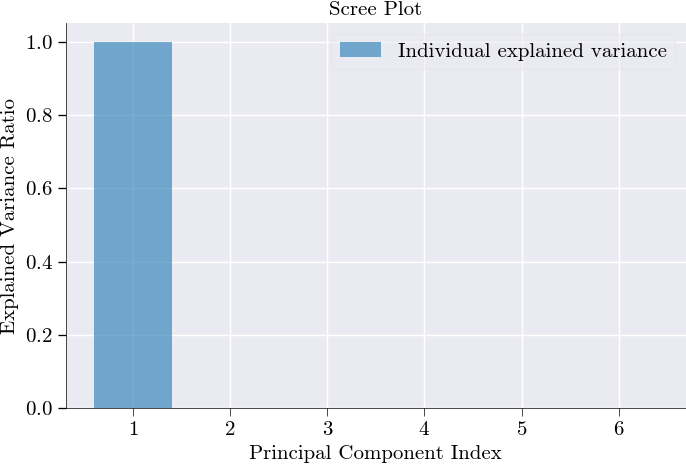

In [8]:
# Plot variance explained by each component
plt.figure(figsize=(8, 5))
plt.bar(range(1, len(explained_variance_ratio)+1),
        explained_variance_ratio,
        alpha=0.6,
        align='center',
        label='Individual explained variance')

plt.xlabel('Principal Component Index')
plt.ylabel('Explained Variance Ratio')
plt.title('Scree Plot')
plt.legend(loc='best')
plt.grid(True)
plt.show()


In [9]:
pc1 = eigenvectors[:,0].reshape(-1,1)

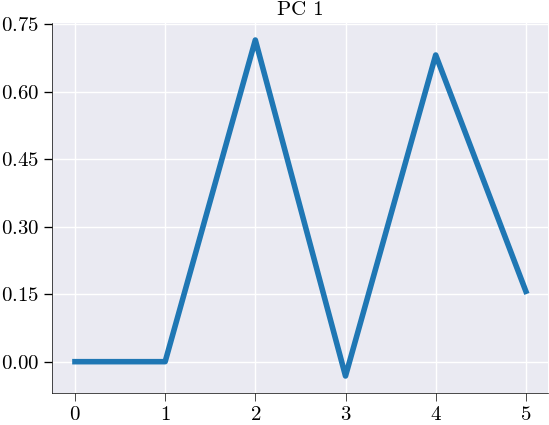

In [10]:
plt.plot(pc1,lw=4)
plt.title("PC 1")
plt.gca().yaxis.set_major_locator(MaxNLocator(nbins=6))  # Set max number of y-ticks

We can rewrite $X$ using PC1

$$
X =
\begin{bmatrix}
x_1(t_1) & y_1(t_1) & x_2(t_1) & y_2(t_1) & x_3(t_1) & y_3(t_1) \\
x_1(t_2) & y_1(t_2) & x_2(t_2) & y_2(t_2) & x_3(t_2) & y_3(t_2) \\
\vdots & \vdots & \vdots & \vdots & \vdots & \vdots \\
x_1(t_n) & y_1(t_n) & x_2(t_n) & y_2(t_n) & x_3(t_n) & y_3(t_n)
\end{bmatrix} = z(t)_{n\times 1}\,\,pc1^\top_{1\times 6}
$$

where $z(t)$ is the coefficient of $pc1$

$$
X \cdot pc1  = z(t)_{n\times 1}
$$

In [11]:
# Step 5: Project data onto principal components
Z_t = X_standardized @ pc1  # mean-centered data


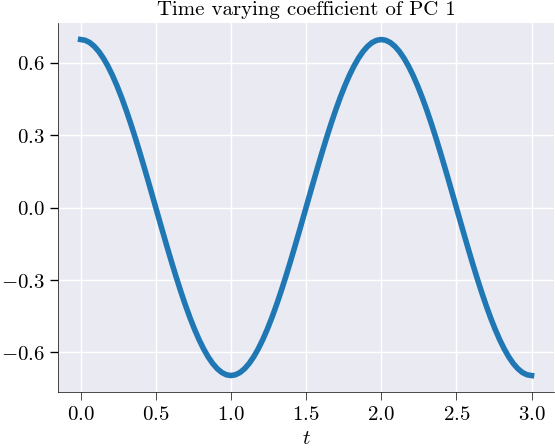

In [12]:
plt.plot(t_values, Z_t,lw=4)
plt.title("Time varying coefficient of PC 1")
plt.xlabel("$t$")
plt.gca().yaxis.set_major_locator(MaxNLocator(nbins=6))  # Set max number of y-ticks

#### Leveraging our understanding of the true dimensionality: reduce data storage

*only store Z_t  and pc1*

In [13]:
np.linalg.norm(X - Z_t@pc1.T)

np.float64(4.112147118009298e-15)

### Using scikit-learn package

pip/conda install scikit-learn

In [14]:
from sklearn.decomposition import PCA

Explained Variance Ratio for each component:
PC1: 1.0000
PC2: 0.0000
PC3: 0.0000
PC4: 0.0000
PC5: 0.0000
PC6: 0.0000


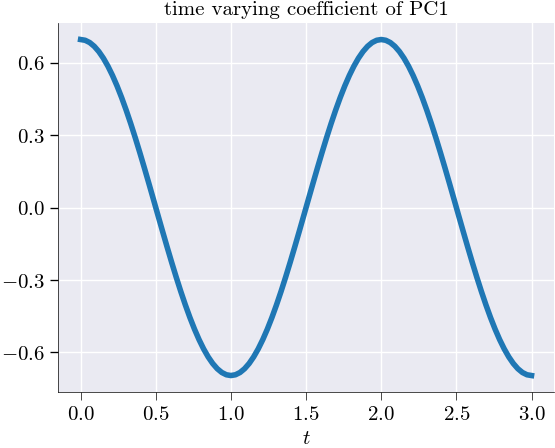

In [15]:
# Perform PCA on the dataset.
pca = PCA()

pca.fit(X)

explained_variance = pca.explained_variance_ratio_

print("Explained Variance Ratio for each component:")

for i, ratio in enumerate(explained_variance):
    print(f"PC{i+1}: {ratio:.4f}")

# Transform the data to the principal component space.
X_pca = pca.transform(X)

# Plot the first principal component time series.
plt.plot(t_values, X_pca[:, 0],lw=4)
plt.title("time varying coefficient of PC1")
plt.gca().yaxis.set_major_locator(MaxNLocator(nbins=6))
plt.xlabel("$t$")
plt.show()


---

---

## Case study -2a: Dimension estimation of 2D Cross-section Data (visual insights into PCA)

In [16]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

Data Generation:

- We create a simple linear dataset with an upward trend (y = x) and add noise to mimic vertical scatter.

- The data is then combined into a 2D array where each row represents a data point.

In [17]:
# ===========================
# 1. Data Generation
# ===========================
# We create a dataset with a linear trend and add noise to resemble the data structure.

# Create 100 equally spaced values for x between -3 and 3
x = np.linspace(-3, 3, 100)


# Generate a base linear relationship: y = 0.2x
# Then add a small noise term to give the trend a slight variation
y = x + 0.05 * np.random.randn(100)

# Add additional vertical scatter to simulate variability similar to the image
y_noise = y + np.random.normal(0, 1.0, size=x.shape)

# Combine x and y_noise into a 2D dataset with two features (columns)
data = np.vstack((x, y_noise)).T

Text(0, 0.5, 'Standardized Feature 2 (Y)')

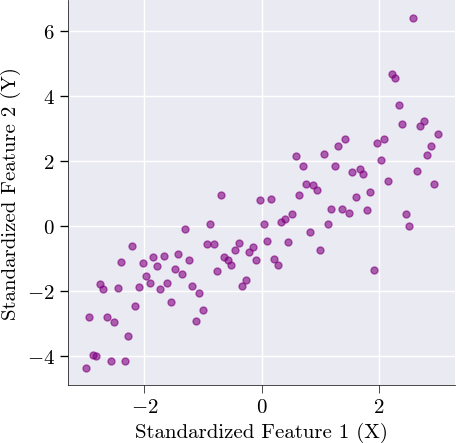

In [18]:
# ===========================
# 4. Plotting the Data 
# ===========================
fig, ax = plt.subplots(figsize=(5, 5))

# Plot the standardized data points
ax.scatter(data[:, 0], data[:, 1], alpha=0.6, color='purple', label='Data',s=25)
ax.set_xlabel("Standardized Feature 1 (X)")
ax.set_ylabel("Standardized Feature 2 (Y)")

Standardization:

We standardize the data so that each feature has zero mean and unit variance. This step is important because PCA is affected by the scale of the data.

In [19]:
# ===========================
# 2. Data Standardization
# ===========================
# PCA is sensitive to the scaling of the data.
# Standardizing ensures that each feature has zero mean and unit variance.

scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

PCA Execution:

- PCA is performed by first computing the covariance matrix of the standardized data.

- The eigenvectors (principal components) and eigenvalues (explained variance) are computed.

- The eigenvector corresponding to the largest eigenvalue (PC1) points in the direction of maximum variance in the data (the spread of the orange dots is maximum in the animation below).

- The second eigenvector (PC2) is orthogonal to PC1 and captures the remaining variance.

<video controls src="media_files/Media1-1.mp4" title="Title"></video>

In [20]:
# ===========================
# 3. Principal Component Analysis (PCA)
# ===========================
# PCA identifies the directions (principal components) where the data varies the most.
# These directions are determined by the eigenvectors of the covariance matrix.

# Create a PCA object to reduce the data to 2 principal components
pca = PCA(n_components=2)

# Fit the PCA on the standardized data
pca.fit(data_scaled)
# Transform the data onto the principal component axes (for potential future use)
data_pca = pca.transform(data_scaled)

# Extract PCA components and explained variance (eigenvalues)
# Components: direction vectors (eigenvectors) of the principal components
components = pca.components_
# Explained variance: how much variance is captured by each principal component
explained_variance = pca.explained_variance_

# Compute the mean of the standardized data (center of the data cloud)
mean = np.mean(data_scaled, axis=0)

# Print explained variance for each component
print("Explained Variance (Eigenvalues):", explained_variance)
print("Principal Components (Eigenvectors):\n", components)

Explained Variance (Eigenvalues): [1.86741402 0.152788  ]
Principal Components (Eigenvectors):
 [[ 0.70710678  0.70710678]
 [-0.70710678  0.70710678]]


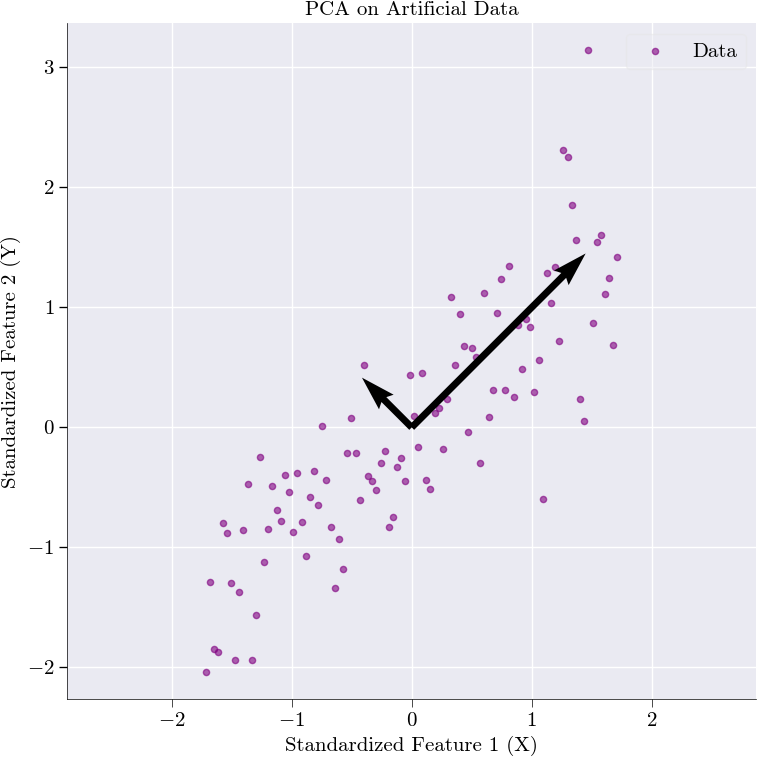

In [21]:
# ===========================
# 4. Plotting the Data and Principal Components
# ===========================
fig, ax = plt.subplots(figsize=(8, 8))

# Plot the standardized data points
ax.scatter(data_scaled[:, 0], data_scaled[:, 1], alpha=0.6, color='purple', label='Data',s=20)

# Plot the principal components (eigenvectors)
# We scale the eigenvectors by the square root of their corresponding eigenvalue for visualization
for length, vector in zip(np.sqrt(explained_variance), components):
    # Scale factor for visualization: multiplying by 1.5 to make the arrows visible
    v = vector * 1.5 * length
    # Plot the arrow starting from the mean of the data
    ax.quiver(*mean, *v, angles='xy', scale_units='xy', scale=1, color='black', width=0.01)

# Add labels, title, grid, and legend
ax.set_title("PCA on Artificial Data")
ax.set_xlabel("Standardized Feature 1 (X)")
ax.set_ylabel("Standardized Feature 2 (Y)")
ax.grid(True)
ax.legend()

# Set equal aspect ratio to ensure arrows are accurately represented
plt.axis('equal')
plt.tight_layout()
plt.show()


## **Summary**

### 1. **The Dataset**
We started with 2D data:
$$
\mathbf{x}_i = \begin{bmatrix} x_i \\ y_i \end{bmatrix}, \quad i = 1, 2, \dots, 100
$$
where:
- $x_i$ are uniformly spaced values between -3 and 3.
- $y_i$ contains a weak linear dependence on $x$ with strong **vertical (second-feature) noise**.
- The shape of the data forms a slightly slanted **cloud elongated along a weak linear trend**.



### 2. **Standardization**
PCA operates on the **covariance structure**, which is sensitive to feature scaling. So we **standardized** the dataset:
- Mean-centered: $\bar{\mathbf{x}} = 0$
- Unit variance: each feature has $\sigma = 1$

After this transformation, PCA works with the **covariance matrix**:
$$
\mathbf{C} = \frac{1}{n-1} \sum_{i=1}^n \mathbf{x}_i \mathbf{x}_i^T = \mathbf{X}^T \mathbf{X}
$$



### 3. **PCA via Eigen Decomposition**
PCA is equivalent to computing the **eigenvectors and eigenvalues** of the covariance matrix $\mathbf{C}$:
- **Eigenvectors**: directions of principal components
- **Eigenvalues**: amount of variance along each direction

Let:
$$
\mathbf{C} \mathbf{v}_j = \lambda_j \mathbf{v}_j
$$
Then:
- $\mathbf{v}_1$: first principal component (PC1)
- $\lambda_1$: variance along PC1

The **eigenvectors are orthogonal**: $\mathbf{v}_1 \perp \mathbf{v}_2$.



### 4. **Visual Interpretation of the Plot**

#### **The Data Cloud**
- Represents **standardized** (mean = 0, std = 1) observations.
- Appears roughly elliptical/slanted vertically.
- Indicates **more variability along PC1**.

#### **Principal Component Arrows**
- **Black arrows** are **eigenvectors (principal components)**.
- **Direction**: shows the axis along which the data has maximum variance.
- **Length**: scaled by $\sqrt{\lambda_j}$, the square root of the eigenvalue — proportional to **standard deviation** along that axis.

So:
- **PC1 (longer arrow)**: captures maximum spread/direction of the data.
- **PC2 (shorter arrow)**: orthogonal residual direction.

This aligns with the statistical notion:
$$
\text{Var}(\mathbf{X} \mathbf{v}_j) = \lambda_j
$$
i.e., variance of the data projected onto $\mathbf{v}_j$ equals the eigenvalue.



### 5. **Explained Variance**
Let’s say the eigenvalues are:
```python
Explained Variance: [1.85, 0.17]
```

Then:
- **PC1 explains**: $\frac{1.85}{1.85 + 0.17} \approx 92\%$ of the total variance.
- **PC2 explains**: $\approx 8\%$

Thus, PC1 is a **good low-dimensional representation** of the data.



### 6. **Geometric Projection**
PCA can also be viewed as **orthogonal projection**:
- Projecting a data point $\mathbf{x}$ onto $\mathbf{v}_1$ gives the **coordinate in reduced space**.
- This is a form of **dimensionality reduction**:
  - Instead of using $(x, y)$, we can describe the data using **just one number**: the projection onto PC1.

Mathematically:
$$
z_1 = \mathbf{v}_1^T \mathbf{x} \quad \text{(scalar)}
$$
Reconstruction:
$$
\hat{\mathbf{x}} = z_1 \mathbf{v}_1
$$



### 7. **Principal Component Space**
Once transformed:
- Original coordinate system is replaced with **uncorrelated principal axes**.
- These axes form a **new orthonormal basis** for the data space.

PCA solves:
- Finding the optimal orthonormal basis that **maximizes variance** and **minimizes reconstruction error**.



### 8. **Statistical Decorrelation**
Original features might be correlated. PCA transforms them into **uncorrelated variables**:
$$
\text{Cov}(\text{PC}_i, \text{PC}_j) = 0 \quad \text{for } i \ne j
$$



### 9. **Compression**
If 92% of the variance is explained by PC1, we can:
- **Ignore PC2** and work only with projections onto PC1.
- This leads to **lossy compression** with minimal error.


| Concept | Interpretation in the Plot |
|--|--|
| **PC1** | Direction of greatest variance |
| **PC2** | Orthogonal direction capturing remaining variance |
| **Arrow length** | √(explained variance), i.e., std deviation |
| **Elliptical data cloud** | More variance along PC1 than PC2 |
| **Standardized data** | Mean 0, variance 1 per feature |
| **PCA transformation** | Rotates and decorrelates the dataset |

---

## Case study -2b: iris dataset

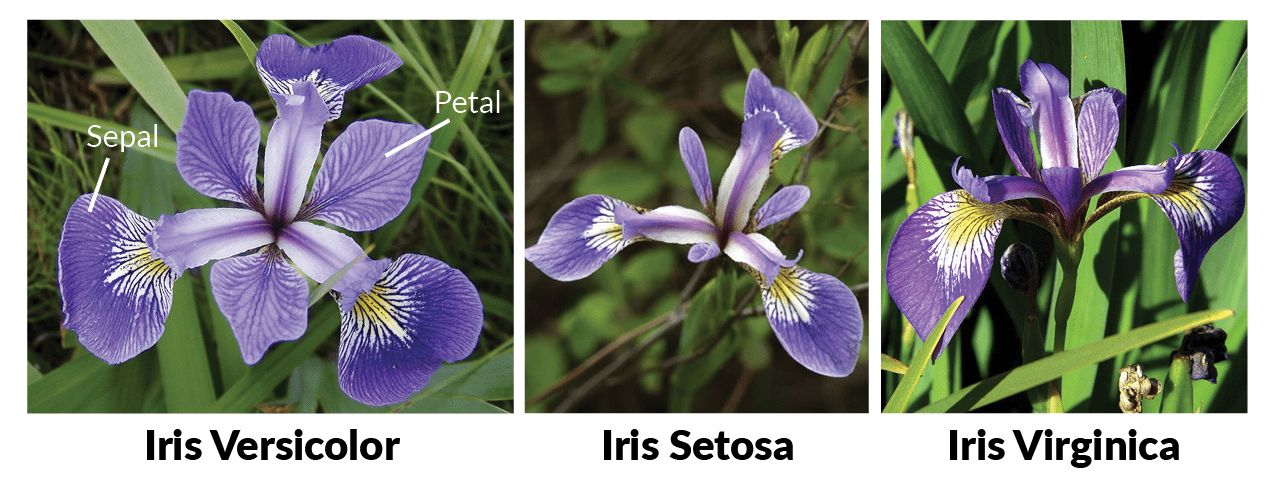

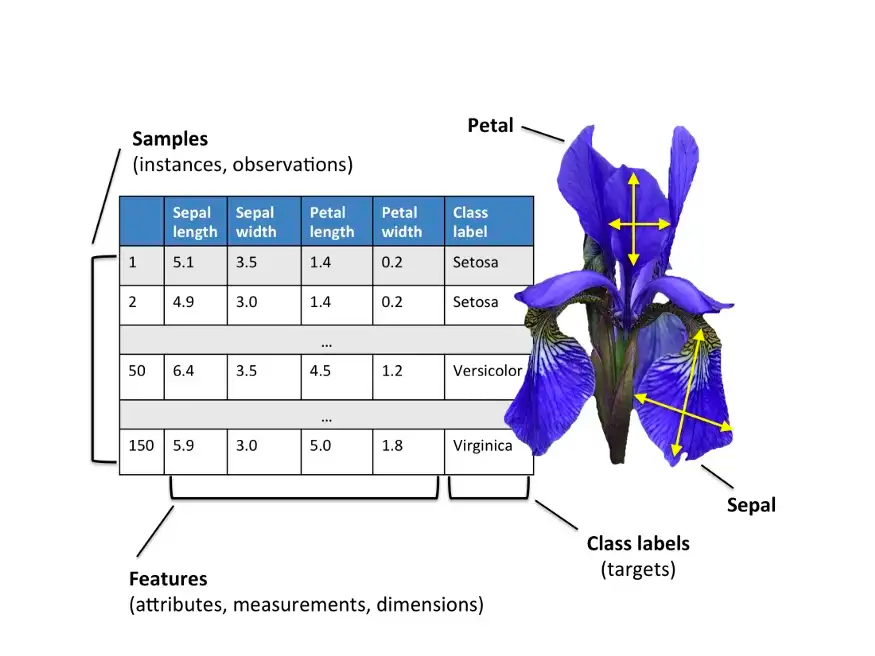

In [22]:
# Principal Component Analysis (PCA) Tutorial using scikit-learn

# ======================================================
# Step 0: Import Required Libraries
# ======================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_iris
import seaborn as sns

# Set Seaborn plotting style
# Apply seaborn style (no grid) and LaTeX rendering
sns.set(style="white", context="notebook", palette="deep")

# Use STIX font and enable LaTeX-style math rendering
plt.rcParams.update({
    "text.usetex": False,             # Use mathtext, not full LaTeX engine
    "mathtext.fontset": "stix",       # Use STIX for math
    "font.family": "STIXGeneral",     # Use STIX for all text
    "axes.grid": False                # Disable grid
})


In [23]:
# ======================================================
# Step 1: Load and Prepare the Dataset
# ======================================================

# Load the Iris dataset from scikit-learn
data = load_iris()

# Create a DataFrame from the feature data
df = pd.DataFrame(data.data, columns=data.feature_names)

# Add the target variable (species) to the DataFrame
df['target'] = data.target

# Display dataset dimensions and sample rows
print("Shape of dataset:", df.shape)
print("\nSample data:")
print(df.head())

Shape of dataset: (150, 5)

Sample data:
   sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  \
0                5.1               3.5                1.4               0.2   
1                4.9               3.0                1.4               0.2   
2                4.7               3.2                1.3               0.2   
3                4.6               3.1                1.5               0.2   
4                5.0               3.6                1.4               0.2   

   target  
0       0  
1       0  
2       0  
3       0  
4       0  



Missing values in each column:
sepal length (cm)    0
sepal width (cm)     0
petal length (cm)    0
petal width (cm)     0
target               0
dtype: int64

Descriptive statistics:
       sepal length (cm)  sepal width (cm)  petal length (cm)  \
count         150.000000        150.000000         150.000000   
mean            5.843333          3.057333           3.758000   
std             0.828066          0.435866           1.765298   
min             4.300000          2.000000           1.000000   
25%             5.100000          2.800000           1.600000   
50%             5.800000          3.000000           4.350000   
75%             6.400000          3.300000           5.100000   
max             7.900000          4.400000           6.900000   

       petal width (cm)      target  
count        150.000000  150.000000  
mean           1.199333    1.000000  
std            0.762238    0.819232  
min            0.100000    0.000000  
25%            0.300000    0.000000  
5

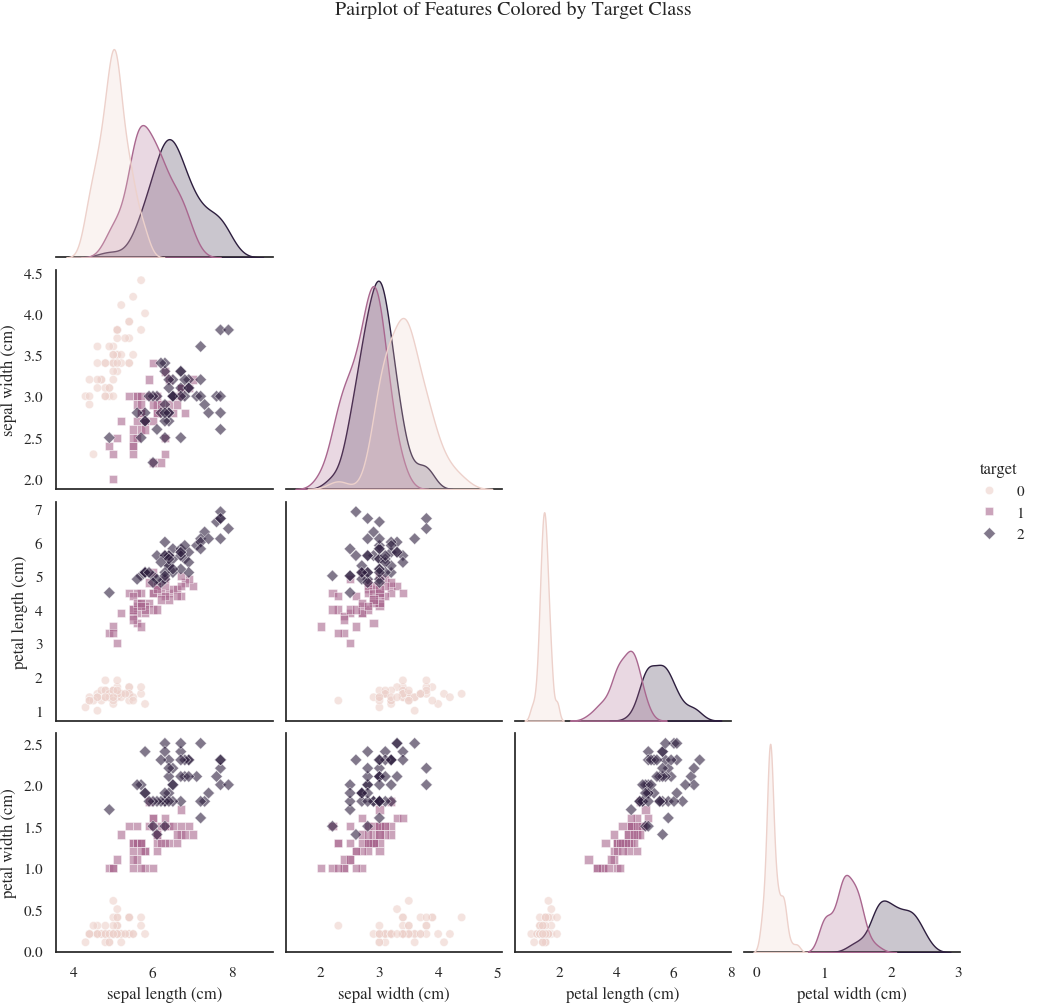


Correlation matrix:
                   sepal length (cm)  sepal width (cm)  petal length (cm)  \
sepal length (cm)           1.000000         -0.117570           0.871754   
sepal width (cm)           -0.117570          1.000000          -0.428440   
petal length (cm)           0.871754         -0.428440           1.000000   
petal width (cm)            0.817941         -0.366126           0.962865   

                   petal width (cm)  
sepal length (cm)          0.817941  
sepal width (cm)          -0.366126  
petal length (cm)          0.962865  
petal width (cm)           1.000000  


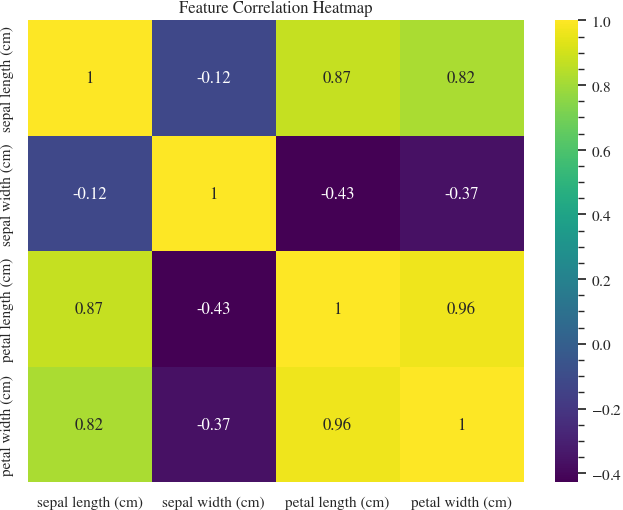

In [24]:
# ======================================================
# Step 2: Exploratory Data Analysis (EDA)
# ======================================================

# Check for missing values
print("\nMissing values in each column:")
print(df.isnull().sum())

# Summary statistics for each feature
print("\nDescriptive statistics:")
print(df.describe())

# Pairplot to visualize distributions and relationships between features
sns.pairplot(df, hue='target', corner=True, diag_kind='kde',
             plot_kws={'alpha': 0.6}, markers=["o", "s", "D"])
plt.suptitle("Pairplot of Features Colored by Target Class", y=1.02)
plt.show()

# Correlation matrix
corr_matrix = df.drop('target', axis=1).corr() ## Does mean centering internally and also does variance normalization.

print("\nCorrelation matrix:")
print(corr_matrix)

# Heatmap of the correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='viridis')
plt.title("Feature Correlation Heatmap")
plt.show()

In [25]:
# ======================================================
# Step 3: Standardize the Features
# ======================================================

# Extract features (exclude the target column)
features = data.feature_names
x = df.loc[:, features].values

# Standardize the feature data to mean=0, variance=1
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)

In [26]:
# ======================================================
# Step 4: Apply PCA
# ======================================================

# Create PCA object to reduce to 2 principal components
pca = PCA(n_components=2)

# Fit PCA on scaled data and transform the data
principal_components = pca.fit_transform(x_scaled)

# Create a new DataFrame with the two principal components
df_pca = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
df_pca['target'] = df['target']

# Explained variance ratio for each component
print("\nExplained variance ratio:")
for i, var in enumerate(pca.explained_variance_ratio_):
    print(f"PC{i+1}: {var:.4f}")

# Cumulative explained variance
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
print("\nCumulative explained variance:")
print(cumulative_variance)


Explained variance ratio:
PC1: 0.7296
PC2: 0.2285

Cumulative explained variance:
[0.72962445 0.95813207]


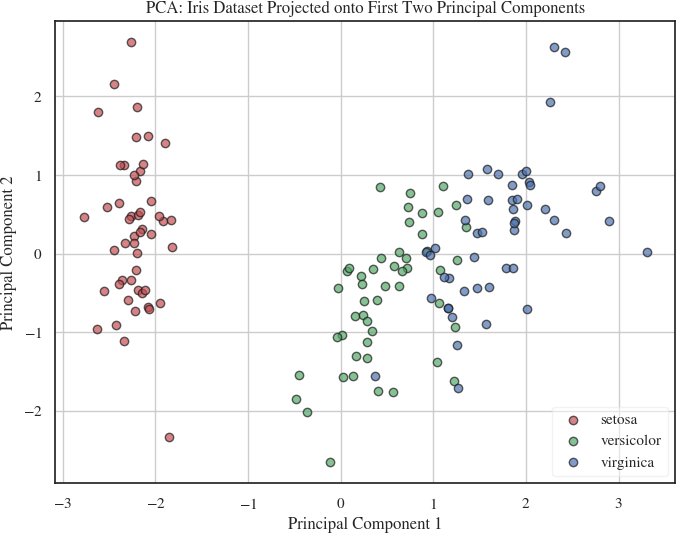

In [27]:
# ======================================================
# Step 5: Visualize PCA Result
# ======================================================

# Scatter plot of the two principal components, colored by species
plt.figure(figsize=(8, 6))
colors = ['r', 'g', 'b']
targets = np.unique(data.target)

for target, color in zip(targets, colors):
    indices = df_pca['target'] == target
    plt.scatter(df_pca.loc[indices, 'PC1'],
                df_pca.loc[indices, 'PC2'],
                c=color,
                label=data.target_names[target],
                alpha=0.7,
                edgecolors='k')

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA: Iris Dataset Projected onto First Two Principal Components')
plt.legend()
plt.grid(True)
plt.show()

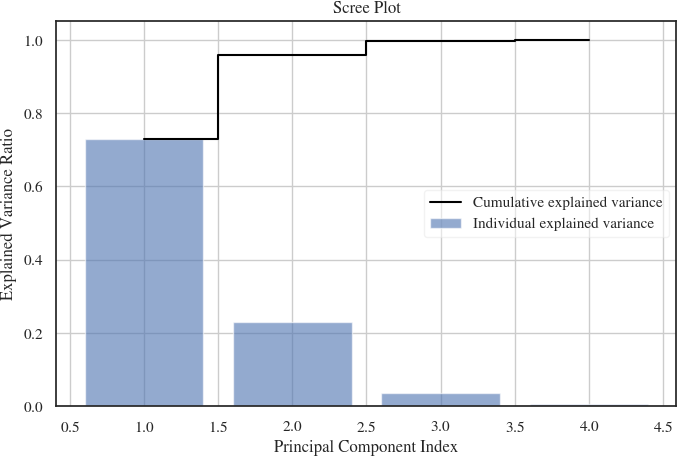

In [28]:
# ======================================================
# Step 6: Scree Plot of Explained Variance
# ======================================================

# Re-run PCA with all components to see variance explained
pca_full = PCA()
pca_full.fit(x_scaled)

# Plot variance explained by each component
plt.figure(figsize=(8, 5))
plt.bar(range(1, len(pca_full.explained_variance_ratio_)+1),
        pca_full.explained_variance_ratio_,
        alpha=0.6,
        align='center',
        label='Individual explained variance')

plt.step(range(1, len(pca_full.explained_variance_ratio_)+1),
         np.cumsum(pca_full.explained_variance_ratio_),
         where='mid',
         label='Cumulative explained variance',
         color='black')

plt.xlabel('Principal Component Index')
plt.ylabel('Explained Variance Ratio')
plt.title('Scree Plot')
plt.legend(loc='best')
plt.grid(True)
plt.show()


In [29]:
# ======================================================
# Step 7: Reconstruct the Original Features from PC Scores
# ======================================================

# Inverse transform: go from PCA space back to scaled features
x_reconstructed_scaled = pca.inverse_transform(principal_components)

# Undo scaling to get back to original feature space
x_reconstructed = scaler.inverse_transform(x_reconstructed_scaled)

# Create a DataFrame of the reconstructed data
df_reconstructed = pd.DataFrame(data=x_reconstructed, columns=features)

print("\nSample of reconstructed data (from 2 PCs):")
print(df_reconstructed.head())



Sample of reconstructed data (from 2 PCs):
   sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)
0           5.018949          3.514854           1.466013          0.251922
1           4.738463          3.030433           1.603913          0.272074
2           4.720130          3.196830           1.328961          0.167414
3           4.668436          3.086770           1.384170          0.182247
4           5.017093          3.596402           1.345411          0.206706


In [30]:
df.head

<bound method NDFrame.head of      sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  \
0                  5.1               3.5                1.4               0.2   
1                  4.9               3.0                1.4               0.2   
2                  4.7               3.2                1.3               0.2   
3                  4.6               3.1                1.5               0.2   
4                  5.0               3.6                1.4               0.2   
..                 ...               ...                ...               ...   
145                6.7               3.0                5.2               2.3   
146                6.3               2.5                5.0               1.9   
147                6.5               3.0                5.2               2.0   
148                6.2               3.4                5.4               2.3   
149                5.9               3.0                5.1               1.8  

### References

1. Greenacre, M., Groenen, P.J.F., Hastie, T. et al. Principal component analysis. Nat Rev Methods Primers 2, 100 (2022).
2. Jolliffe, I. T. (2002). Principal component analysis (2nd ed.). Springer. (Springer Series in Statistics)
3. https://github.com/Carl-McBride-Ellis/TOBoML?tab=readme-ov-file
4. https://youtu.be/kDgtXdeCbZg
5. https://youtu.be/FgakZw6K1QQ
6. https://youtu.be/a9jdQGybYmE

## Credit

#### Suparno Bhattacharyya

_Institute of Data Science_

_Texas A&M University_